In [1]:
import string
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3
import os
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, Bidirectional,
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
#define the constants

WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048
max_length = 47
vocab_size = 2039
embedding_dim = 200
START = "<start>"
STOP = "<end>"

next_words = 91
max_sequence_len = 15
total_words = 7228

In [3]:
encode_model = InceptionV3(weights='imagenet')
encode_model = Model(encode_model.input, encode_model.layers[-2].output)
preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input

In [4]:
def encodeImage(img):
  # Resize all images to a standard size (specified bythe image 
  # encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for 
  # the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM )
  return x

In [5]:
#load the data stored used for prediction

root_captioning = "./caption_model/"
train_path = os.path.join(root_captioning,"data",f'train{OUTPUT_DIM}.pkl')
with open(train_path, "rb") as fp:
  encoding_train = pickle.load(fp)

In [6]:
wordtoidx_path = "./caption_model/data/wordtoidx.pkl"
with open(wordtoidx_path, "rb") as fp:
  wordtoidx = pickle.load(fp)

idxtoword_path = "./caption_model/data/idxtoword.pkl"
with open(idxtoword_path, "rb") as fp:
  idxtoword = pickle.load(fp)

In [7]:
token_path = "./sonnet_model/data/tokenizer.pkl"
with open(token_path, "rb") as fp:
  tokenizer = pickle.load(fp)

In [8]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [9]:
model_path = "./caption_model/caption-model.hdf5"
caption_model.load_weights(model_path)

In [10]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [11]:
sonnetModel = Sequential()
sonnetModel.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
sonnetModel.add(Bidirectional(LSTM(150)))
sonnetModel.add(Dense(total_words, activation='softmax'))
# sonnetModel = Adam(lr=0.01)

In [12]:
model_path = "./sonnet_model/sonnet-model.hdf5"
sonnetModel.load_weights(model_path)

In [13]:
def genSonnet(seed_text):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = sonnetModel.predict_classes(token_list, verbose=0)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word

    seed_text = seed_text.split(" ")

    i=0
    for word in seed_text: 
        if i%7 == 0:
            print()
        if i%28==0:
            print()
        print(word, end = " ") 
        i = i+1

In [14]:
def genSonnetFromImg(photo):
    print('Sonnet')
    seed_phrase = generateCaption(photo)
    genSonnet(seed_phrase)

In [15]:
img_path = input('Enter the path to the image')
print(img_path)

Enter the path to the image./test3.jpeg
./test3.jpeg


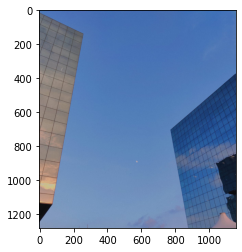

In [16]:
#img_path = "./test.jpg"

img = Image.open(img_path)
img.load()

plt.imshow(img)
plt.show()

img = encodeImage(img).reshape((1,OUTPUT_DIM))

In [18]:
genSonnetFromImg(img)

Sonnet


A man is standing on the sidewalk 
holding a baby. like the delight whereon 
thine fear again of ease recline trespass 
conquest tokens sensibly still arose his forge 

retires beyond thy fear away you bed 
tenets 'd of tune their way streaking 
bright in fear of reach sinner been 
enjoy of fear each dusky wing is 

balanc 'd flow nor gaze on fear 
of fear of beauty health of cold 
command gallant crew aghast of fear of 
fear of age hating continuance fear their 

mind of blazing panes fear of solemn 
trace fear around moon bathers of steel 
pain to relate 